# Deep Learning &mdash; Assignment 5

Fifth assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Construct a PyTorch `DataSet`
1. Train and modify a transformer network
1. Experiment with a translation dataset

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` for PyTorch,
* `d2l`, the library that comes with the [Dive into deep learning](https://d2l.ai) book.  
  Note: if you get errors, make sure the right version of the d2l library is installed:
  `pip install d2l==1.0.0a1.post0`

All libraries can be installed with `pip install`.

In [ ]:
%matplotlib inline
from d2l import torch as d2l
import math
from random import Random
from typing import List
import numpy as np
import torch
from torch import nn
from torch.utils.data import (IterableDataset, DataLoader)
import matplotlib.pyplot as plt

device = d2l.try_gpu()

## 5.1 Learning to calculate (5 points)

In this assignment we are going to train a neural network to do mathematics.
When communicating between humans, mathematics is expressed with words and formulas.
The simplest of these are formulas with a numeric answer. For example, we might ask what is `100+50`, to which the answer is `150`.

To teach a computer how to do this task, we are going to need a dataset.

Below is a function that generates a random formula. Study it, and see if you understand its parameters.

In [ ]:
def random_integer(length: int, signed: bool = True, rng: Random = Random()):
    max = math.pow(10, length)
    min = -max if signed else 0
    return rng.randint(min, max)


def random_formula(complexity: int, signed: bool = True, rng: Random = Random()):
    """
    Generate a random formula of the form "a+b" or "a-b".
    complexity is the maximum number of digits in the numbers.
    """
    a = random_integer(complexity, signed, rng)
    b = random_integer(complexity, False, rng)
    is_addition = not signed or rng.choice([False, True])
    if is_addition:
        return (f"{a}+{b}", str(a + b))
    else:
        return (f"{a}-{b}", str(a - b))

In [ ]:
seed = 123456
random_formula(3, rng=Random(seed))

Note that the `rng` argument allows us to reproduce the same random numbers, which you can verify by running the code below multiple times. But if you change the seed to `None` then the random generator is initialized differently each time.

In [ ]:
def random_formulas(complexity, signed, count, seed):
    """
    Iterator that yields the given count of random formulas
    """
    rng = Random(seed)
    for i in range(count):
        yield random_formula(complexity, signed, rng=rng)


for q, a in random_formulas(3, True, 5, seed):
    print(f'{q} = {a}')

...We are going to treat these expressions as sequences of tokens, where each character is a token. In addition we will need tokens to denote begin-of-sequence and end-of-sequence, as well as padding, for which we will use `'<bos>'`, `'<eos>'`, and `'<pad>'` respectively, as is done in the book.

[d2l chapter 9.2](https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html) includes an example of tokenizing a string, and it also defines a `Vocab` class that handles converting the tokens to numbers.

For this dataset we know beforehand what the vocabulary will be.

### Creating a vocabulary

**(a) What are the tokens in this dataset? Complete the code below.<span style="float:right"> (1 point)</span>**

In [ ]:
vocab = d2l.Vocab(['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '+', '-'],
                  reserved_tokens=['<eos>', '<pad>', '<bos>'])

We can print the vocabulary to double check that it makes sense:

In [ ]:
print('Vocabulary size:', len(vocab))
print('Vocabulary:', vocab.idx_to_token)

Note that the d2l Vocab class includes a `'<unk>'` token, for handling unknown tokens in the input.

We are now ready to tokenize and encode formula.

**(b) Complete the code below.<span style="float:right"> (1 point)</span>**

In [ ]:
def tokenize_and_encode(string: str, vocab=vocab) -> List[int]:
    chars = [*string]
    ret = vocab[chars]
    ret.append(vocab['<eos>'])
    return ret

Let's test it on a random formula:

In [ ]:
q, a = random_formula(3, rng=Random(seed))
print('The question', q, 'and answer', a)
print('are encoded as', tokenize_and_encode(q), 'and', tokenize_and_encode(a))

# Check tokenize_and_encode
assert ''.join(vocab.to_tokens(tokenize_and_encode(q))) == q + '<eos>'
assert len(tokenize_and_encode(q)) == len(q) + 1

### Padding and trimming

Next, to be able to work with a whole dataset of these encoded sequences, they all need to be the same length.

**(c) Implement the function below that pads or trims the encoded token sequence as needed.<span style="float:right"> (1 point)</span>**

Hint: see [d2l section 10.5.3](http://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html#loading-sequences-of-fixed-length) for a very similar function.

In [ ]:
def pad_or_trim(tokens: List[int], target_length: int, vocab=vocab):
    if len(tokens) > target_length:
        return tokens[:target_length]
    else:
        pad_token = vocab['<pad>']
        for _ in range(target_length - len(tokens)):
            tokens.append(pad_token)
        return tokens

In [ ]:
# pad or trim q to get a sequence of 10 tokens
pad_or_trim(tokenize_and_encode(q), 10)

In [ ]:
# Check pad_or_trim
assert len(pad_or_trim([1, 2, 3, 4, 5], 10)) == 10
assert len(pad_or_trim(list(range(20)), 10)) == 10
assert vocab.to_tokens(pad_or_trim([1, 2, 3, 4, 5], 10)[5:]) == ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], \
    f"Incorrect padding tokens, found {vocab.to_tokens(pad_or_trim([1, 2, 3, 4, 5], 10)[5:])}"

### Translating tokens

We can use `vocab.to_tokens` to convert the encoded token sequence back to something more readable:

In [ ]:
vocab.to_tokens(pad_or_trim(tokenize_and_encode(q), 10))

For convenience, we define the `decode_tokens` function to convert entire lists or tensors:

In [ ]:
def decode_tokens(t, vocab=vocab):
    # convert a list, tensor, or array of encoded tokens
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
    t = np.asarray(t)
    return np.asarray(vocab.to_tokens(list(t.flatten()))).reshape(*t.shape)


# convert all tokens at once
print(decode_tokens([pad_or_trim(tokenize_and_encode('513+1323'), 10),
                     pad_or_trim(tokenize_and_encode('412+42'), 10)]))

### Creating a dataset

The most convenient way to use a data generating function for training a neural network is to wrap it in a PyTorch `Dataset`. In this case, we will use an [IterableDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset), which can be used as an iterator to walk over the samples in the dataset.

**(d) Complete the code below.<span style="float:right"> (1 point)</span>**

In [ ]:
class FormulaDataset(IterableDataset):
    def __init__(self, complexity, signed, count, seed=None, vocab=vocab):
        self.seed = seed
        self.complexity = complexity
        self.signed = signed
        self.count = count
        self.vocab = vocab
        self.max_question_length = 2 * complexity + 3
        self.max_answer_length = complexity + 2

    def __iter__(self):
        formulas = random_formulas(self.complexity, self.signed, self.count, self.seed)
        for f in formulas:
            x_encoded = tokenize_and_encode(f[0], self.vocab)
            y_encoded = tokenize_and_encode(f[1], self.vocab)
            x_padded = pad_or_trim(x_encoded, self.max_question_length, self.vocab)
            y_padded = pad_or_trim(y_encoded, self.max_answer_length, self.vocab)
            yield torch.tensor(x_padded), torch.tensor(y_padded)

    # Complete the class definition.
    #       See the documentation for IterableDataset for examples.
    #       Make sure that the values yielded by the iterator are pairs of torch tensors.
    #       To create a repeatable dataset, always start with the same random seed.

**(e) Define a training set with 10000 formulas and a validation set with 5000 formulas, both with complexity 3.<span style="float:right"> (1 point)</span>**

Note: make sure that the training and validation set are different.

In [ ]:
complexity = 3
signed = True
train_data = FormulaDataset(3, True, 10000, seed, vocab)
val_data = FormulaDataset(3, True, 5000, seed + 1, vocab)

As usual, we wrap each dataset in a `DataLoader` to create minibatches.

In [ ]:
# Define data loaders
batch_size = 125
data_loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size),
    'val': torch.utils.data.DataLoader(val_data, batch_size=batch_size),
}

In [ ]:
# The code below checks that the datasets are defined correctly
train_loader = data_loaders['train']
val_loader = data_loaders['val']

from typing import Tuple
from typing_extensions import assert_type

for (name, loader), expected_size in zip(data_loaders.items(), [10000, 5000]):
    first_batch = next(iter(loader))
    assert len(first_batch) == 2, \
        f"The {name} dataset should yield (question, answer) pairs when iterated over."
    assert torch.is_tensor(first_batch[0]), \
        f"The questions in the {name} dataset should be torch.tensors"
    assert tuple(first_batch[0].shape) == (batch_size, 2 * complexity + 3), \
        f"The questions in the {name} dataset should be of size (batch_size, max_question_length), i.e. {batch_size, 2 * complexity + 3}, found {tuple(first_batch[0].shape)}"
    assert first_batch[0].dtype in [torch.int32, torch.int64], \
        f"The questions in the {name} dataset should be encoded as integers, found {first_batch[0].dtype}"
    assert torch.equal(next(iter(loader))[0], next(iter(loader))[0]), \
        f"The {name} dataset should be deterministic, it should produce the same data each time"
    assert all([len(batch[0]) == batch_size for batch in iter(loader)]), \
        f"Batches should all have the right size. Perhaps the batch size does not evenly divide the dataset size?"
    assert sum([len(batch[0]) for batch in iter(loader)]) == expected_size, \
        f"{name} dataset does not have the right size, expected {expected_size}, found {sum([len(batch[0]) for batch in iter(loader)])}."
assert not torch.equal(next(iter(train_loader))[0], next(iter(val_loader))[0]), \
    "The training data and validation data should not be the same"

## 5.2 Transformer inputs (10 points)

There is a detailed description of the transformer model in [chapter 11 of the d2l book](http://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html). We will not use most the code from the book, and instead use [PyTorch's built-in Transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

However, some details we still need to implement ourselves.

### Masks

Training a transformer uses masked self-attention, so we need some masks. Here are two functions that make these masks.

In [ ]:
def generate_square_subsequent_mask(size, device=device):
    """
    Mask that indicates that tokens at a position are not allowed to attend to
    tokens in subsequent positions.
    """
    mask = (torch.tril(torch.ones((size, size), device=device))) == 0
    return mask


def generate_padding_mask(tokens, padding_token):
    """
    Mask that indicates which tokens should be ignored because they are padding.
    """
    return tokens == torch.tensor(padding_token)

**(a) Generate a padding mask for a random encoded token string.<span style="float:right"> (1 point)</span>**

Hint: make sure that `tokens` is a torch.tensor.

In [ ]:
q, a = random_formula(3, rng=Random(seed))
tokens = torch.tensor(pad_or_trim(tokenize_and_encode(q, vocab), 10))
padding_mask = generate_padding_mask(tokens, vocab['<pad>'])
print(tokens)
print(decode_tokens(tokens))
print(padding_mask)

In [ ]:
# More tests
assert list(generate_padding_mask(torch.tensor(pad_or_trim(tokenize_and_encode("1+1"), 8)), vocab['<pad>'])) == [
    False] * 4 + [True] * 4, "Something is wrong with generate_padding_mask"

**(b) How will this mask be used by a transformer?<span style="float:right"> (1 point)</span>**

The masks make sure the transformer network does not put its attention to input that it should not use for training, e.g., because it contains the answer. This would happen, because we use self-attention in our model.

The code below takes the first batch of data from the training set, and it generates a shifted version of the target values.

In [ ]:
x, y = next(iter(train_loader))
bos = torch.tensor(vocab['<bos>']).expand(y.shape[0], 1)
y_prev = torch.cat((bos, y[:, :-1]), axis=1)

# print the first five samples
print(decode_tokens(y)[:5])
print(decode_tokens(y_prev)[:5])

**(c) Look at the values for the example above. What is `y_prev` used for during training of a transformer model?<span style="float:right"> (1 point)</span>**

`y_prev` will be used as queries, as we use self-attention in our model. `y` will then serve as the correct answers to the queries.

**(d) Why do some rows of `y_prev` end in `'<eos>'`, but not all? Is this a problem?<span style="float:right"> (1 point)</span>** 

Because some sequences were already full, shifting it by one will "throw out" the last, i.e., the `<eos>` token. This is not a problem, as we only use `y_prev` as queries and not as values. Therefore, the only thing we would predict after a `<eos>` token would always be the `<pad>` token, which we are not interested in, anyway. What is interesting, though, is to predict when a sentence ends, which we can still verify to be correct as `y` keeps the correct answers.

The code below illustrates what the output of `generate_square_subsequent_mask` looks like.

In [ ]:
square_subsequent_mask = generate_square_subsequent_mask(y.shape[1])

print(square_subsequent_mask.shape)
print(square_subsequent_mask)

**(e) How and why should this mask be used? State your answer in terms of `x`,  `y` and/or `y_prev`.<span style="float:right"> (1 point)</span>**

Using the square_subsequent_mask to mask `y_prev` we make sure that during the learning, the network cannot simply look at the correct answers by looking one value forward. For example, for the first query from `y_prev`, i.e. `<bos>` we do not want the network to simply look at the second value of `y_prev` as this would be the correct value to the query.

**(f) Give an example where it could make sense to use a different mask in a transformer network, instead of the `square_subsequent_mask`?<span style="float:right"> (1 point)</span>**

For example, if you want to recover partially lost data of a sequence, i.e., if there are scratches in a CD. Here, we would allow looking at data that is a bit away from the current query in both directions, i.e., we would need a mask that does not allow to look at data close to the query.

### Embedding

Our discrete vocabulary is not suitable as the input for a transformer. We need an embedding function to map our input vocabulary to a continuous, high-dimensional space.

We will use the `torch.nn.Embedding` class to for this. As you can read in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding), this class maps each token in our vocabulary to a specific point in embedding space, its embedding vector. We will use this embedding vector as the input features for the next layer of our model.

The parameters of the embedding are trainable: the embedding vector of each token is optimized along with the rest of the network.

**(g) Define an embedding that maps our vocabulary to a 5-dimensional space.<span style="float:right"> (1 point)</span>**

In [ ]:
embedding = nn.Embedding(len(vocab), 5)
print(embedding)

Let's apply the embedding to some sequences from our training set.

In [ ]:
# take the first batch
x, y = next(iter(train_loader))
# take three samples
x = x[:3]
# print the shapes
print(x)
print(embedding(x))
print(x.shape)
print(embedding(x).shape)

**(h) Explain the output shape.<span style="float:right"> (1 point)</span>**

The shape of x is the number of equations x number of tokens in each equation.

The shape of the embedding adds another dimension of 5 to represent each encoded character of the equation as a vector of five dimensions.

The size of the embedding vectors, or the dimensionality of the embedding space, does not depend on the number of tokens in our vocabulary. We are free to choose an embedding size that fits our problem.

For example, let's try an embedding with 2 dimensions, and plot the initial embedding for the tokens in our vocabulary.

**(i) Create an embedding with 2 dimensions and plot the embedding for all tokens.<span style="float:right"> (no points)</span>**

In [ ]:
embedding = nn.Embedding(len(vocab), 2)

# embed all tokens of our vocabulary
x = torch.arange(len(vocab))
emb = embedding(x).detach().cpu().numpy()

plt.scatter(emb[:, 0], emb[:, 1]);
for i, token in enumerate(vocab.idx_to_token):
    plt.annotate(token, (emb[i, 0] + 0.04, emb[i, 1]))

As always, we need to balance the complexity of our networks: a larger embedding will increase the number of parameters in our model, but increase the risk of overfitting.

**(j) Would this 2-dimensional embedding space be large enough for our problem?<span style="float:right"> (1 point)</span>**

No, two dimensions are probably not enough, as we do not only have to encode the different tokens, which are very limited in our case, but also all possible positions, using the positional encoding. Otherwise, the transformer network does not have a sense of order.

Instead of using an embedding, we could also use a simple one-hot encoding to map the words in the vocabulary to feature vectors. However, practical applications of natural language processing never do this. Why not?

**(k) Explain the practical advantage of embeddings over one-hot encoding.<span style="float:right"> (1 point)</span>**

Embeddings are more recourse efficient, as they are encoded as floating point numbers while a one-hot encoding would be a huge vector with the size of the dictionary. This is probably bigger.

Additionally, this means that the whole vocabulary needs to be known upfront and cannot be chaned easily afterwards, while you can just add another token into the embedding.

## 5.3 `torch.nn.Transformer` (8 points)

<div style="float: left"><a href="https://cs.ru.nl/~gvtulder/vaswani-fig-1-highlight.png"><img src="https://cs.ru.nl/~gvtulder/vaswani-fig-1-highlight.png" width="300"></a></div>

We now have all required inputs for our transformer.

Consult the documentation for the [`torch.nn.Transformer`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) class of PyTorch. This class implements a full Transformer as described in ["Attention Is All You Need"](https://arxiv.org/pdf/1706.03762.pdf), the paper that introduced this architecture.

The `Transformer` class implements the main part of the of the Transformer architecture, shown highlighted in the image on the left (see also Fig. 1 in "Attention Is All You Need").

For a given input sequence, it applies one or more encoder layers, followed by one or more decoder layers, to compute an output sequence that we can then process further.

Because the `Transformer` class takes care of most of the complicated parts of the model, we can concentrate providing the inputs and outputs: the grayed-out areas in the image.

Check out the parameters for the `Transformer` class and the inputs and outputs of its `forward` function.
<br style="clear: both">

**(a) Which parameter of the `Transformer` class should we base on our embedding?<span style="float:right"> (1 point)</span>**

The `d_model` param is equal to the dimensions of the embedding.

**(b) Given fixed input and output dimensions, which parameters of the `Transformer` can we use to change the complexity of our network?<span style="float:right"> (1 point)</span>**

- nhead
- num_encoder_layers
- num_decoder_layers
- dim_feedforward
- bias

**(c) When using the `Transformer` class, where should we use the masks that we defined earlier?<span style="float:right"> (1 point)</span>**

We will need both, the padding and the square_subsequent_mask in the `forward` function. The square_subsequent_mask will be applied to `y_prev` and therefore given as the `tgt_mask` param of the `forward` function. As we also want to ignore the padding of the input, the output and in the handling from the decoder to the encoder, we have to give pad-masking of the input to the `pad_mask_src` and `memory_key_padding_mask` as well as the pad masking applied to the output to the `tgt_key_padding_mask` parameter.

### Building a network

**(d) Complete the code for the TransformerNetwork.<span style="float:right"> (5 points)</span>**

Construct a network with the following architecture (see the image in the previous section for an overview):
1. An embedding layer that embeds the input tokens into a space of size `dim_hidden`.
2. A dropout layer (not shown in the image).
3. A [Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) with the specified parameters (`dim_hidden`, `num_heads`, `num_layers`, `dim_feedforward`, and `dropout`).<br>Note: you will need to pass `batch_first=True`, to indicate that the first dimension runs over the batch and not over the sequence.
4. A final linear prediction layer that takes the output of the transformer to `dim_vocab` possible classes.

Don't worry about positional encoding for now, we will add that later.

The `forward` function should generate the appropriate masks and combine the layers defined in `__init__` to compute the output.

In [ ]:
class TransformerNetwork(torch.nn.Module):
    def __init__(self,
                 dim_vocab=len(vocab), padding_token=vocab['<pad>'],
                 num_layers=2, num_heads=4, dim_hidden=64, dim_feedforward=64,
                 dropout=0.01, positional_encoding=False):
        super().__init__()
        self.padding_token = padding_token
        self.embedding = nn.Embedding(len(vocab), dim_hidden, device=device)
        self.dropout = nn.Dropout(dropout)
        self.transformer = nn.Transformer(dim_hidden, num_heads, num_layers, num_layers, dim_feedforward, dropout,
                                          batch_first=True, device=device)
        self.predict = nn.Linear(dim_hidden, dim_vocab, device=device)
        if positional_encoding:
            self.pos_encoding = PositionalEncoding(dim_hidden)
        else:
            self.pos_encoding = torch.nn.Identity()

    def forward(self, src, tgt):
        pad_mask_src = generate_padding_mask(src, self.padding_token).to(device)
        pad_mask_tgt = generate_padding_mask(tgt, self.padding_token).to(device)
        subseq_mask_tgt = generate_square_subsequent_mask(tgt.shape[1]).to(device)

        src = src.to(device)
        tgt = tgt.to(device)

        embedded_src = self.embedding(src)
        pos_encoded_src = self.pos_encoding(embedded_src)
        embedded_tgt = self.embedding(tgt)
        pos_encoded_tgt = self.pos_encoding(embedded_tgt)
        dropped_src = self.dropout(pos_encoded_src)

        transformed = self.transformer(dropped_src, pos_encoded_tgt, tgt_mask=subseq_mask_tgt,
                                       src_key_padding_mask=pad_mask_src, tgt_key_padding_mask=pad_mask_tgt,
                                       memory_key_padding_mask=pad_mask_src)
        return self.predict(transformed)

**(e) Try the transformer with an example batch.**

In [ ]:
net = TransformerNetwork(dim_feedforward=72)
x, y = next(iter(train_loader))
bos = torch.tensor(vocab['<bos>']).expand(y.shape[0], 1)
y_prev = torch.cat((bos, y[:, :-1]), axis=1)

print('x.shape', x.shape)
print('y.shape', y.shape)
print('y_prev.shape', y_prev.shape)

y_pred = net(x, y_prev)
print('y_pred.shape', y_pred.shape)

# check the shape against what we expected
np.testing.assert_equal(list(y_pred.shape), [y.shape[0], y.shape[1], len(vocab)])

We can convert these predictions to tokens (but they're obviously random):

In [ ]:
print(decode_tokens(torch.argmax(y_pred, dim=2))[:5])

In [ ]:
# Check that the transformer is defined correctly
assert isinstance(net.embedding, torch.nn.Embedding)
assert isinstance(net.dropout, torch.nn.Dropout)
assert isinstance(net.transformer, torch.nn.Transformer)
assert isinstance(net.predict, torch.nn.Linear)
# Check parameters of transformer
assert net.transformer.d_model == 64
assert net.transformer.nhead == 4
assert net.transformer.batch_first == True
assert net.transformer.encoder.num_layers == 2
assert net.transformer.decoder.num_layers == 2
assert net.transformer.encoder.layers[0].linear1.out_features == 72
assert net.dropout.p == 0.01
assert net.transformer.encoder.layers[0].dropout.p == 0.01
# Check that the forward function behaves correctly
net.train(False)
assert torch.all(torch.isclose( \
    net(x, y_prev), \
    net(torch.cat((x, torch.tensor(vocab['<pad>']).expand(x.shape[0], 5)), axis=1), y_prev), atol=1e-5)), \
    "Adding padding to x should not affect the output of the network. Check src_key_padding_mask and memory_key_padding_mask. The former controls self attention to padding tokens in the encoder, the latter controls cross attention from decoder to encoder."
assert torch.all(torch.isclose( \
    net(x, y_prev), \
    net(x, torch.cat((y_prev, torch.tensor(vocab['<pad>']).expand(y.shape[0], 5)), axis=1))[:, :-5], atol=1e-5)), \
    "Adding padding to y should not affect the output of the network. Check tgt_key_padding_mask."
assert torch.all(torch.isclose( \
    net(x, y_prev)[:, :2], \
    net(x, y_prev[:, :2]), atol=1e-5)), \
    "The presence of later tokens in y should not affect the output for earlier tokens. Check tgt_mask."
assert torch.all(torch.isclose( \
    net(x, y_prev), \
    net(torch.flip(x, [1]), y_prev), atol=1e-5)), \
    "Order of x should not matter for a transformer network. Check src_mask."
assert not torch.all(torch.isclose( \
    net(x, torch.flip(y_prev, [1])), \
    torch.flip(net(x, y_prev), [1]), atol=1e-5)), \
    "Order of y should matter for a transformer network. Check tgt_mask."

## 5.4 Training (10 points)

### Training loop

We will base the training code on last week's code. A complication in computing the loss and accuracy are the padding tokens. So, before we work on the training loop itself, we need to update the `accuracy` function so it ingores these `<pad>` tokens. Let's do this in a generic way

**(a) Copy the `accuracy` function from last week, and add a parameter `ignore_index`. The tokens with `y == ignore_index` should be ignored.<span style="float:right"> (1 point)</span>**

Hint: you can select elements from a tensor with `some_tensor[include]` where `include` is a tensor of booleans.

In [ ]:
def accuracy(y_hat, y, ignore_index=None):
    # Computes the mean accuracy.
    # y_hat: raw network output (before sigmoid or softmax)
    #        shape (samples, classes)
    # y:     shape (samples)
    if y_hat.shape[1] == 1:
        # binary classification
        y_hat = (y_hat[:, 0] > 0).to(y.dtype)
    else:
        # multi-class classification
        y_hat = torch.argmax(y_hat, axis=1).to(y.dtype)
    mask = [y != ignore_index]
    y = y[mask]
    y_hat = y_hat[mask]
    correct = (y_hat == y).to(torch.float32)
    return torch.mean(correct)

In [ ]:
# Test the accuracy function.
assert accuracy(torch.tensor([[1, 0, 0], [0.4, 0.5, 0.1], [0, 1, 0], [0.4, 0.1, 0.5]]), torch.tensor([0, 1, 2, 2]),
                1) == 2 / 3
assert accuracy(torch.tensor([[1, 0, 0], [0.4, 0.5, 0.1], [0, 1, 0], [0.4, 0.1, 0.5]]), torch.tensor([0, 1, 2, 2]),
                2) == 1
assert accuracy(torch.tensor([[1, 0, 0], [0.4, 0.5, 0.1], [0, 1, 0], [0.4, 0.1, 0.5]]), torch.tensor([0, 1, 2, 2]),
                3) == 3 / 4
assert accuracy(torch.tensor([[1, 0, 0], [0.4, 0.5, 0.1], [0, 1, 0], [0.4, 0.1, 0.5]]), torch.tensor([2, 2, 1, 2]),
                2) == 1

**(b) Write a training loop for the transformer model.<span style="float:right"> (4 points)</span>**

See last week's assignment for inspiration.
The code is mostly the same with the following changes:
 * The cross-entropy loss function and accuracy should ignore all `<pad>` tokens. (Use `ignore_index`, see the [documentation of CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).)
 * The network expects `y_prev` as an extra input.
 * The output of the network contains a batch of N samples, with maximum length L, and gives logits over C classes, so it has size (N,L,C). But `CrossEntropyLoss` and `accuracy` expect a tensor of size (N,C,L). You can use [torch.Tensor.transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html) to change the output to the right shape.

In [33]:
def train(net, data_loaders, epochs=100, lr=0.001, device=device):
    """
    Trains the model net with data from the data_loaders['train'] and data_loaders['val'].
    """
    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    animator = d2l.Animator(xlabel='epoch',
                            legend=['train loss', 'train acc', 'validation loss', 'validation acc'],
                            figsize=(10, 5))

    timer = {'train': d2l.Timer(), 'val': d2l.Timer()}

    ignore_index = vocab['<pad>']
    bos_token = vocab['<bos>']

    for epoch in range(epochs):
        # monitor loss, accuracy, number of samples
        metrics = {'train': d2l.Accumulator(3), 'val': d2l.Accumulator(3)}

        for phase in ('train', 'val'):
            # switch network to train/eval mode
            net.train(phase == 'train')

            for i, (x, y) in enumerate(data_loaders[phase]):
                timer[phase].start()

                # move to device
                x = x.to(device)
                y = y.to(device)

                # compute prediction
                bos = torch.tensor(bos_token).expand(y.shape[0], 1)
                bos = bos.to(device)
                y_prev = torch.cat((bos, y[:, :-1]), axis=1)
                y_hat = net(x, y_prev)
                y_hat = torch.transpose(y_hat, 1, 2)

                if y_hat.shape[1] == 1:
                    # compute binary cross-entropy loss
                    loss = torch.nn.BCEWithLogitsLoss()(y_hat[:, 0], y.to(torch.float))
                else:
                    # compute cross-entropy loss
                    loss = torch.nn.CrossEntropyLoss(ignore_index=ignore_index)(y_hat, y)

                if phase == 'train':
                    # compute gradients and update weights
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                metrics[phase].add(loss * x.shape[0],
                                   accuracy(y_hat, y, ignore_index=ignore_index) * x.shape[0],
                                   x.shape[0])

                timer[phase].stop()

        animator.add(epoch + 1,
                     (metrics['train'][0] / metrics['train'][2],
                      metrics['train'][1] / metrics['train'][2],
                      metrics['val'][0] / metrics['val'][2],
                      metrics['val'][1] / metrics['val'][2]))

    train_loss = metrics['train'][0] / metrics['train'][2]
    train_acc = metrics['train'][1] / metrics['train'][2]
    val_loss = metrics['val'][0] / metrics['val'][2]
    val_acc = metrics['val'][1] / metrics['val'][2]
    examples_per_sec = metrics['train'][2] * epochs / timer['train'].sum()

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val loss {val_loss:.3f}, val acc {val_acc:.3f}')
    print(f'{examples_per_sec:.1f} examples/sec '
          f'on {str(device)}')

### Experiment

**(c) Train a transformer network. Use 100 epochs with a learning of 0.001<span style="float:right"> (no points)</span>**

train loss 1.129, train acc 0.606, val loss 1.878, val acc 0.440
13658.3 examples/sec on cuda:0


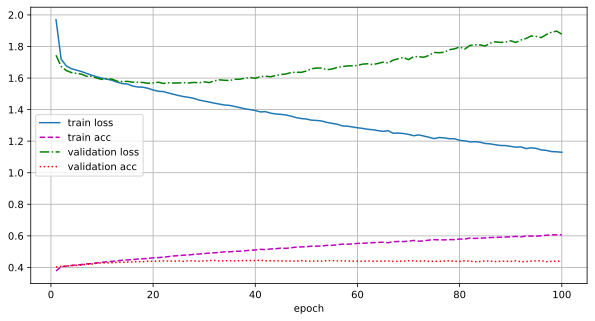

In [34]:
network = TransformerNetwork()
train(network, data_loaders, device=device)

**(d) Briefly discuss the results. Has the training converged? Is this a good calculator?<span style="float:right"> (1 point)</span>**

The model does not perform well, we can see a clear overfitting, and the validation loss is not better than 44%. One reason could be that the network does not take the order of the input into account yet. It is definitely not a good calculator.

**(e) Run the trained network with input `"123+123"` and `"321+321"`.<span style="float:right"> (1 point)</span>**

In [35]:
def predict(net, q, a):
    # Run net to predict the output given the input `q` and y_prev based on `a`.
    # Return predicted y
    with torch.no_grad():
        q = torch.tensor(tokenize_and_encode(q, vocab), device=device)
        a = torch.tensor(tokenize_and_encode(a, vocab), device=device)
        a = a.expand(1, a.shape[0])
        q = q.expand(1, q.shape[0])

        bos = torch.tensor(vocab['<bos>']).expand(a.shape[0], 1)
        bos = bos.to(device)
        y_prev = torch.cat((bos, a[:, :-1]), axis=1)

        return net.forward(q, y_prev)


for src, tgt in [('123+123', '246'), ('321+321', '642')]:
    print(f'For {src}={tgt}')
    y_pred = predict(net, src, tgt)
    print('  y_pred[0]', y_pred[0])
    print('  encoded', torch.argmax(y_pred, dim=-1))
    print('  tokens', decode_tokens(torch.argmax(y_pred, dim=-1)))
    print()

For 123+123=246
  y_pred[0] tensor([[-0.6133, -0.3234,  0.1821, -0.2321, -0.0590,  1.1770,  0.7525, -0.0442,
         -0.2217,  0.6128, -0.2270, -0.4906,  0.3464, -0.0059,  0.0481,  0.7970],
        [-0.3533,  0.2239, -0.0592, -0.7336, -0.8406,  0.9331,  1.1886, -0.0455,
         -0.2803,  0.8367, -0.0075, -0.7127,  0.5795, -0.8274,  0.3109,  1.1793],
        [-0.5181, -0.2928, -0.1004,  0.0942, -0.4017,  0.6692,  0.7906,  0.7665,
          0.1339,  0.3142,  0.1458, -0.2955,  0.5791, -0.2986, -0.5221, -0.1576],
        [-0.8632, -0.0277, -0.1198, -0.8462, -1.2161,  0.8989,  0.6691,  0.1064,
         -0.0666,  0.5998,  0.2940, -0.3687, -0.3294, -0.5386,  0.2205,  0.7166]],
       device='cuda:0')
  encoded tensor([[5, 6, 6, 5]], device='cuda:0')
  tokens [['3' '4' '4' '3']]

For 321+321=642
  y_pred[0] tensor([[-0.6133, -0.3234,  0.1821, -0.2321, -0.0590,  1.1770,  0.7525, -0.0442,
         -0.2217,  0.6128, -0.2270, -0.4906,  0.3464, -0.0059,  0.0481,  0.7970],
        [-0.9104, -0.168

/home/max/DataspellProjects/ru-deep-learning-23-24/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/home/max/DataspellProjects/ru-deep-learning-23-24/venv/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


**(f) Compare the predictions for the first element of y with the two different inputs. Can you explain what happens?<span style="float:right"> (1 point)</span>**

The first element of the prediction is the same. This is because the transformer network is agnostic to the order of inputs, and therefore, both inputs look the same to the network. When predicting, the first token of `y_prev` is the same for both sequences. Therefore, the first digit has the exact same input and thus the same output. The tokens predicted afterward are different, as the values of `y_prev` do now differ for both queries.

**(g) Does the validation accuracy estimate how often the model is able to answers formulas correctly? Explain your answer.<span style="float:right"> (1 point)</span>**

No, the validation accuracy is not very helpful in our case, as it tells us how may digits have been correctly estimated. For a working calculator though, we need all digits to be correct for a correct output. Thus, the accuracy given is too high compared to a realistic accuracy.

**(h) If the forward function takes the shifted output `y_prev` as input, how can we use it if we don't know the output yet?<span style="float:right"> (1 point)</span>**

We can feed it the output we have generated so far for every step, and pad rest, such that it gets ignored.

## 5.5 Positional encoding (5 points)

We did not yet include positional encoding in the network.
PyTorch does not include such an encoder, so here we copied the code from the book (slightly modified):

In [36]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""

    def __init__(self, num_hiddens, max_len=1000):
        super().__init__()
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        return X + self.P[:, :X.shape[1], :].to(X.device)

**(a) Add positional encoding to the TransformerModel.<span style="float:right"> (point given in earlier question)</span>**

In [37]:
# See over there.

**(b) Construct and train a network with positional encoding<span style="float:right"> (1 point)</span>**

train loss 0.126, train acc 0.959, val loss 0.117, val acc 0.963
13586.6 examples/sec on cuda:0


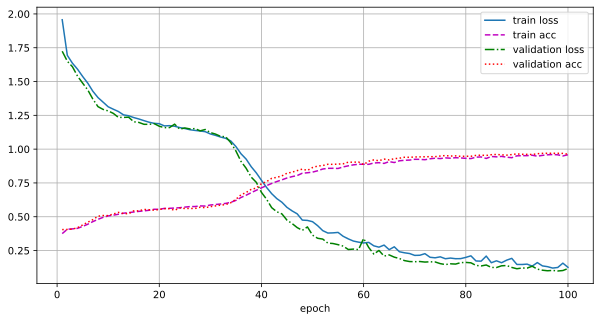

In [38]:
net_pos = TransformerNetwork(positional_encoding=True)
train(net_pos, data_loaders, device=device)

**(c) How does the performance of a model with positional encoding compare to a model without?<span style="float:right"> (1 point)</span>**

The network with positional encoding outperforms the one without positional encoding by far. The model does not seem to overfit, and it reaches a far better accuracy (~99%) and loss, for both the training and the validation data. Still, the accuracy may not be overrated, as it describes the accuracy per output digit and not per correct total output. For a three-digit output, the change of it being correct would be around $0.988^3 \approx 96.4\% $ 

**(d) Run the trained network with input `"123+123"` and `"321+321"`.<span style="float:right"> (no points)</span>**

In [39]:
for src, tgt in [('123+123', '246'), ('321+321', '642')]:
    print(f'For {src}={tgt}')
    y_pred = predict(net_pos, src, tgt)
    print('  y_pred[0]', y_pred[0])
    print('  encoded', torch.argmax(y_pred, dim=-1))
    print('  tokens', decode_tokens(torch.argmax(y_pred, dim=-1)))
    print()

For 123+123=246
  y_pred[0] tensor([[ -4.9034,   0.5860,   3.7699,  13.9296,  19.7151,  14.7271,  -1.5040,
         -18.1147, -17.6060, -11.6169,  -2.9846,   2.4058,  -3.0202,  -4.3274,
          -3.4440,  -3.3316],
        [ -4.5576,  -1.7120,  -5.6537,  -3.2112,   3.2994,  14.8669,  18.4981,
           9.2267,   0.1884,  -7.4943,  -9.9372,  -8.1305,  -4.5996,  -5.9595,
          -3.9704,  -3.8745],
        [ -1.6757,  -1.0997,  -6.5203, -10.8100, -13.7973,  -9.4673,   2.8247,
          15.9281,  20.6612,  12.5928,  -0.9201,  -7.6857,  -1.7224,   3.1345,
          -1.4175,  -1.0383],
        [ -0.7615,   6.4692,  -2.4379,  -5.5822,  -8.5725,  -6.4657,  -1.8769,
           2.3440,   6.8317,   4.8302,  -1.2497,  -4.6150,  -0.0439,  16.6441,
          -0.0573,  -0.4289]], device='cuda:0')
  encoded tensor([[ 4,  6,  8, 13]], device='cuda:0')
  tokens [['2' '4' '6' '<eos>']]

For 321+321=642
  y_pred[0] tensor([[ -1.8682,   0.4696,  -6.9170, -13.3869, -14.8059,  -8.5794,   3.6265,
       

**(e) Compare the predictions for the first element of y with what you found earlier. Can you explain what happens?<span style="float:right"> (1 point)</span>**

Other than in the first try, which did not have a positional encoding yet, the transformer is now aware of the order of inputs and can thus predict the correct first digit, even if `y_prev` is the same for the first output. This is simply the case because `123` and `321` does not encode to the same anymore.

**(f) Explain in your own words why positional encoding is used in transformer networks.<span style="float:right"> (1 point)</span>**

Positional encoding is used in transformer networks as the self-attention mechanism is agnostic to the position of values, as all values get added together. Adding positional encoding makes it possible to add a sense of order of the inputs to the transformer network. 

**(g) Look at the learning curve. Can you suggest a way to improve the model?<span style="float:right"> (1 point)</span>**

The model does not seem to overfit at all so far, which may give room to increase the number of parameters in the network, i.e., make it more complex. We could do that for example, by increasing the number of layers or the embedding size. 

**(h) Optional: if time permits, try to train an even better model**

## 5.6 Predicting for new samples (5 points)

Predicting an output given a new sample requires an appropriate search algorithm (see [d2l chapter 10.8](https://d2l.ai/chapter_recurrent-modern/beam-search.html)). Here, we will implement the simplest form: a greedy search algorithm that selects the token with the highest probability at each time step.

**(a) Describe this search strategy in pseudo-code.<span style="float:right"> (1 point)</span>**

```python
while next_token != '<eos>' && max length not reached:
    predict_next_token = net.forward(input, output_so_far)
    next_token = max(predict_next_token)
    output_so_far.append(next_token)
```

**(b) Implement a greedy search function to predict a sequence using `net_pos`.<span style="float:right"> (2 points)</span>**

In [40]:
def predict_greedy(net, src, length):
    # predict an output sequence of the given (maximum) length given input string src
    with torch.no_grad():
        src = torch.tensor(tokenize_and_encode(src, vocab), device=device)
        src = src.expand(1, src.shape[0])

        a = torch.ones([1, length], device=device, dtype=torch.int32) * vocab['<pad>']

        bos = torch.tensor(vocab['<bos>']).expand(a.shape[0], 1)
        bos = bos.to(device)
        y_prev = torch.cat((bos, a[:, :-1]), axis=1)
        for i in range(length - 1):
            y_pred = net(src, y_prev)
            encoded = torch.argmax(y_pred, dim=-1)
            y_prev[:, i + 1] = encoded[:, i]
            if encoded[0, i] == vocab['<eos>']:
                encoded[0, i + 1:] = vocab['<pad>']
                break
        return encoded


predicted_sequence = predict_greedy(net_pos, '123+123', 6)
print(decode_tokens(predicted_sequence))

[['2' '4' '6' '<eos>' '<pad>' '<pad>']]


**(c) Does this search strategy give a high-quality prediction? Why, or why not?<span style="float:right"> (1 point)</span>**

In general, the greedy search strategy does not provide the best result, as a token that is likely to come next may lead to all the following tokens becoming very unlikely, such that the full path is not very likely. Trying out a few values gives the impression that for our limited problem, the greedy search seems to be sufficiently good. 

**(d) What alternative search strategy could we use to improve the predictions? Why would this help?<span style="float:right"> (1 point)</span>**

An alternative to Greedy Search is Beam Search. It can improve the prediction quality, because it considers multiple possible paths through the search space, which may lead to a higher certainty of the network over the whole prediction, even if some individual predictions did not have the highest certainty.

In theory, we could also use an exhaustive search through all possibilities, but in practice this is not possible given the computational resources.

## 5.7 Discussion (4 points)

Last week, we looked at recurrent neural networks such as the LSTM. Both recurrent neural networks and transformers work with sequences, but in recent years the transformer has become more popular than the recurrent models.

**(a) An advantage of transformers over recurrent neural is that they can be faster to train. Why is that?<span style="float:right"> (1 point)</span>**

This is because the transformers have a direct connection between the inputs of a sequence, while for training the LSTMs the gradients have to be propagated through a long way. Especially for long sequences, this is a problem.

This also leads to the possibility to train transformer networks in parallel, while LSTMs have to be trained sequentially.

**(b) Does this advantage also hold when predicting outputs for new sequences? Why, or why not?<span style="float:right"> (1 point)</span>**

During consumption of the existing data that should be continued, translated, or similar, the transformer can still run in parallel, during the prediction phase, though, both architectures have to run sequentially. This reduces the speed benefit of transformers over LSTMs. 

**(c) Why is positional encoding often used in transformers, but not in convolutional or recurrent neural networks?<span style="float:right"> (1 point)</span>**

A transformer network does not have a sense of order by itself, as it processes all inputs simultaneously. Therefore, it needs these added information as positional encodings.

RRNs process a sequences of data as such, i.e., the order of input does matter to these architectures. This makes positional encoding superfluous.

Convolutional networks only process data that is close to the target position. The kernel decides on how to weight each position. Therefore, we also do not need a positional encoding in this architecture.

The structure of a recurrent neural network makes it very suitable for online predictions, such as real-time translation, because it only depends on prior inputs. You can design an architecture where the RNN produces an output token for every input token given to it, and it can produce that output without having to wait for the rest of the input.

Note: 'online' means producing outputs continuously as new input comes in, as opposed to collecting a full dataset and analyzing it afterwards, it has nothing to do with the internet.

**(d) How would a transformer work in an online application? Do you need to change the architecture?<span style="float:right"> (1 point)</span>**

To make a transformer work with online data, it would need to start the whole computation every time it gets a new input, i.e., process everything seen so far plus the new token from the very beginning. This would be very computing intensive.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 47 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 3c66915 / 2023-10-04</span>